# IMPORT Library

In [5]:
pip install surprise 

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
     |████████████████████████████████| 11.8 MB 4.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619450 sha256=731420b45322ef3c6b0f321de59234dbfdd49b48e8085b3f005d3fd841754600
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import numpy as np 
import scipy as sp
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [3]:
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [6]:
import time
from surprise import KNNWithMeans
from surprise import KNNBasic, SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD DATA 

In [8]:
ratings = pd.read_csv("/content/drive/MyDrive/Video_Games_Amazon/ratings_Video_Games.csv",names=['userId', 'productId','rating','timestamp'])

In [9]:
reviews = pd.read_csv("/content/drive/MyDrive/Video_Games_Amazon/details_Video_Games.csv")

In [10]:
ratings.head()

,userId,productId,rating,timestamp
0,AB9S9279OZ3QO,0078764343,5.0,1373155200
1,A24SSUT5CSW8BH,0078764343,5.0,1377302400
2,AK3V0HEBJMQ7J,0078764343,4.0,1372896000
3,A10BECPH7W8HM7,043933702X,5.0,1404950400
4,A2PRV9OULX1TWP,043933702X,5.0,1386115200


In [11]:
reviews.head()

,category,title,brand,productId
0,Video Games| PC| Games,Reversi Sensory Challenger,Fidelity Electronics,42000742
1,Video Games| Xbox 360| Games,Medal of Honor Warfighter - Includes Battlefie...,by\n \n EA Games,78764343
2,Video Games| Retro Gaming Microconsoles| Supe...,street fighter 2 II turbo super nintendo snes ...,Nintendo,276425316
3,Video Games| Xbox 360| Accessories| Controller...,Xbox 360 MAS STICK,by\n \n MAS SYSTEMS,324411812
4,Video Games| PC| Games| Grades 2-12| Spelling...,Phonics Alive 3 The Speller,by\n \n Advanced Software Pty Ltd,439335310


In [12]:
print("Total Reviews:",ratings.shape[0])
print("Total Columns:",ratings.shape[1])

Total Reviews: 1324753
Total Columns: 4


In [13]:
print("Total number of ratings :",ratings.rating.nunique())
print("Total number of users   :", ratings.userId.nunique())
print("Total number of products  :", ratings.productId.nunique())


Total number of ratings : 5
Total number of users   : 826767
Total number of products  : 50210


In [14]:
print("Total number of products  :", reviews.productId.nunique())

Total number of products  : 68137


In [15]:
ratings.shape

(1324753, 4)

In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324753 entries, 0 to 1324752
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1324753 non-null  object 
 1   productId  1324753 non-null  object 
 2   rating     1324753 non-null  float64
 3   timestamp  1324753 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 40.4+ MB


# Xử lí Data 

In [17]:
# Kiểm tra giá trị thiếu
ratings.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [18]:
# Kiểm tra data trùng 
ratings[ratings.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [19]:
ratings.describe()['rating']

count    1.324753e+06
mean     3.978754e+00
std      1.378987e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


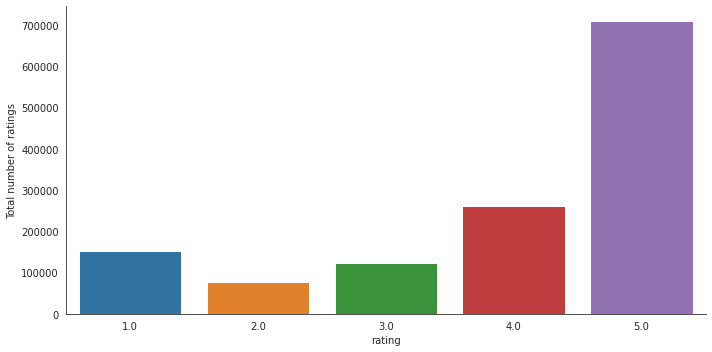

In [20]:
# phân bố các giá trị rating
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=ratings, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [21]:
ratings['rating'].mean()

3.9787537752320623

In [22]:
# xoá cột timestamp
ratings.drop(['timestamp'], axis=1,inplace=True)

# Phân tích rating của sản phẩm 


In [23]:
# ratings trung bình của sản phẩm 
rating_df = pd.DataFrame(ratings.groupby('productId')['rating'].mean())
rating_df['ratings_count'] = pd.DataFrame(ratings.groupby('productId')['rating'].count())
rating_df['ratings_average'] = pd.DataFrame(ratings.groupby('productId')['rating'].mean())
rating_df.head(10)

,rating,ratings_count,ratings_average
productId,,,
0078764343,4.666667,3,4.666667
043933702X,4.000000,4,4.000000
0439339960,3.000000,1,3.000000
0439339987,5.000000,1,5.000000
0439342260,4.000000,1,4.000000
0439374391,5.000000,1,5.000000
0439394422,4.000000,2,4.000000
043940133X,3.285714,7,3.285714
0439573947,4.666667,3,4.666667


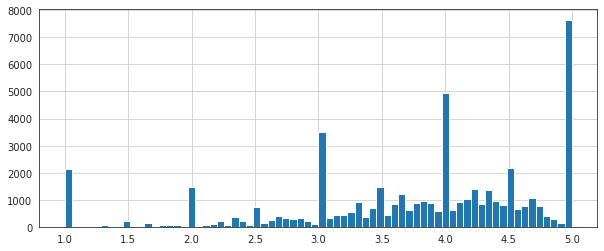

In [24]:
plt.figure(figsize=(10,4))
rating_df['rating'].hist(bins=70)

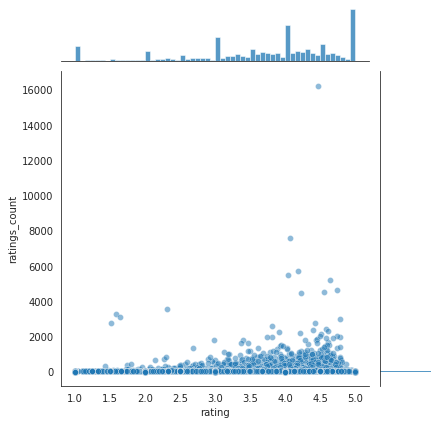

In [25]:
sns.jointplot(x='rating',y='ratings_count',data=rating_df,alpha=0.5)

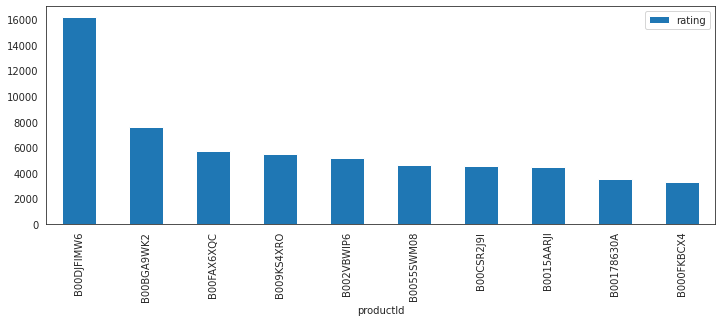

In [26]:
# 10 sản phẩm hàng đầu
popular_products = pd.DataFrame(ratings.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(10).plot(kind = "bar",figsize=(12, 4))

# split data train/test 6-4


In [27]:
# lấy ra top những người dùng có 20 rating trở lên 
userID = ratings.groupby('userId').count()

In [28]:
top_user = userID[userID['rating'] >= 20].index

In [29]:
topuser_ratings_df = ratings[ratings['userId'].isin(top_user)]

In [30]:
topuser_ratings_df.shape

(80305, 3)

In [31]:
topuser_ratings_df.head()

,userId,productId,rating
36,AFWPLXT2OD6H1,0439715571,4.0
37,A1P478YKNZYVXE,0439715571,4.0
51,A1E2ODNEYJ1UWX,0545112141,5.0
96,A361M14PU2GUEG,0700099867,4.0
109,A1QJJU33VNC4S7,0700099867,4.0


In [32]:
topuser_ratings_df.sort_values(by='rating', ascending=False).head()

,userId,productId,rating
294702,A239MFM40GO85W,B000E991PC,5.0
256856,A2V8TXWEV92R94,B0009VXBAQ,5.0
576065,A25BJ6ZTGRNR3L,B001P2M532,5.0
256826,A2HV7RYD2T30DD,B0009VXBAQ,5.0
256839,A330K1NZBFVCO2,B0009VXBAQ,5.0


In [33]:
topuser_ratings_df.shape

(80305, 3)

Lấy những Sản phẩm có 15 ratings trở lên 

In [34]:
# lấy  những sản phẩm có 15 ratings trở lên 
prodID = ratings.groupby('productId').count()

In [35]:
top_prod = prodID[prodID['rating'] >= 15].index

In [36]:
top_ratings_df = topuser_ratings_df[topuser_ratings_df['productId'].isin(top_prod)]

In [37]:
top_ratings_df.sort_values(by='rating', ascending=False).head()

,userId,productId,rating
1324455,A2IGEPJJYKMOWK,B00KAI3KW2,5.0
313707,A3ACFBM9NWUQMG,B000FOQE24,5.0
777001,A3DWI49RAMSADS,B003O6E800,5.0
777009,A29X45MA3LZK25,B003O6E800,5.0
313930,A1H4NFXAJQRQ2K,B000FPM3HS,5.0


In [38]:
top_ratings_df.shape

(67255, 3)

In [39]:
top_ratings_df.userId.nunique(), top_ratings_df.productId.nunique()


(2060, 10913)

Chia train/test 60/40

In [40]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(top_ratings_df, test_size = 0.40, random_state=0)

In [41]:
reader = Reader(rating_scale=(1, 5))

In [42]:
data= Dataset.load_from_df(top_ratings_df[['userId', 'productId', 'rating']],reader)

In [43]:
# Split data to train and test
from surprise.model_selection import train_test_split

In [44]:
trainset, testset = train_test_split(data, test_size = 0.40, random_state=0)

In [45]:
train_data.userId.nunique(),  train_data.productId.nunique()



(2059, 9509)

In [46]:
test_data.userId.nunique(), test_data.productId.nunique()

(2055, 8154)

# BUILD

In [60]:
def merge_rating_true_pred(
    rating_true,
    rating_pred,
    col_user='userId',
    col_item='productId',
    col_rating='rating',
    col_prediction='prediction',
):
    """Join truth and prediction data frames on userID and itemID and return the true
    and predicted rated with the correct index.
    Args:
        rating_true (pandas.DataFrame): True data
        rating_pred (pandas.DataFrame): Predicted data
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
    Returns:
        numpy.ndarray: Array with the true ratings
        numpy.ndarray: Array with the predicted ratings
    """
    suffixes = ["_true", "_pred"]
    rating_true_pred = pd.merge(
        rating_true, rating_pred, on=[col_user, col_item], suffixes=suffixes
    )
    if col_rating in rating_pred.columns:
        col_rating = col_rating + suffixes[0]
    if col_prediction in rating_true.columns:
        col_prediction = col_prediction + suffixes[1]
    return rating_true_pred[col_rating], rating_true_pred[col_prediction]

In [61]:
def mae(
    rating_true,
    rating_pred,
    col_user='userId',
    col_item='productId',
    col_rating='rating',
    col_prediction='prediction',
):
    """Calculate Mean Absolute Error.
    Args:
        rating_true (pandas.DataFrame): True data. There should be no duplicate (userID, itemID) pairs
        rating_pred (pandas.DataFrame): Predicted data. There should be no duplicate (userID, itemID) pairs
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
    Returns:
        float: Mean Absolute Error.
    """

    y_true, y_pred = merge_rating_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
    )
    return mean_absolute_error(y_true, y_pred)

In [62]:
def compute_ranking_predictions(algo,data,usercol='userId',itemcol='productId',predcol='prediction',remove_seen=False,):
    preds_lst = []
    users = data[usercol].unique()
    items = data[itemcol].unique()

    for user in users:
        for item in items:
            preds_lst.append([user, item, algo.predict(user, item).est])

    all_predictions = pd.DataFrame(data=preds_lst, columns=[usercol, itemcol, predcol])

    if remove_seen:
        tempdf = pd.concat(
            [
                data[[usercol, itemcol]],
                pd.DataFrame(
                    data=np.ones(data.shape[0]), columns=["dummycol"], index=data.index
                ),
            ],
            axis=1,
        )
        merged = pd.merge(tempdf, all_predictions, on=[usercol, itemcol], how="outer")
        return merged[merged["dummycol"].isnull()].drop("dummycol", axis=1)
    else:
        return all_predictions

In [63]:
def predict(
    algo,
    data,
    usercol='userId',
    itemcol='productId',
    ratingcol = 'rating',
    predcol='prediction',
):
    predictions = [
        algo.predict(getattr(row, usercol), getattr(row, itemcol),getattr(row, ratingcol))
        for row in data.itertuples()
    ]
    predictions = pd.DataFrame(predictions)
    predictions = predictions.rename(
        index=str, columns={"uid": usercol, "iid": itemcol, "est": predcol, 'r_uid': ratingcol}
    )
    return predictions.drop(["details"], axis="columns")

In [64]:
def rmse(
    rating_true,
    rating_pred,
    col_user='userId',
    col_item='productId',
    col_rating='rating',
    col_prediction='prediction',
):
    """Calculate Root Mean Squared Error
    Args:
        rating_true (pandas.DataFrame): True data. There should be no duplicate (userID, itemID) pairs
        rating_pred (pandas.DataFrame): Predicted data. There should be no duplicate (userID, itemID) pairs
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
    Returns:
        float: Root mean squared error
    """

    y_true, y_pred = merge_rating_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
    )
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [65]:
def get_top_k_items(
    dataframe, col_user='userId', col_rating='rating', k=5
):
    """Get the input customer-item-rating tuple in the format of Pandas
    DataFrame, output a Pandas DataFrame in the dense format of top k items
    for each user.
    Note:
        If it is implicit rating, just append a column of constants to be
        ratings.
    Args:
        dataframe (pandas.DataFrame): DataFrame of rating data (in the format
        customerID-itemID-rating)
        col_user (str): column name for user
        col_rating (str): column name for rating
        k (int or None): number of items for each user; None means that the input has already been
        filtered out top k items and sorted by ratings and there is no need to do that again.
    Returns:
        pandas.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    """
    # Sort dataframe by col_user and (top k) col_rating
    if k is None:
        top_k_items = dataframe
    else:
        top_k_items = (
            dataframe.groupby(col_user, as_index=False)
            .apply(lambda x: x.nlargest(k, col_rating))
            .reset_index(drop=True)
        )
    # Add ranks
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=False).cumcount() + 1
    return top_k_items

In [66]:
def ndcg_at_k(
    rating_true,
    rating_pred,
    col_user='userId',
    col_item='productId',
    col_rating='rating',
    col_prediction='prediction',
    relevancy_method="top_k",
    k=5,
    threshold=5
):
    """Normalized Discounted Cumulative Gain (nDCG).
    Info: https://en.wikipedia.org/wiki/Discounted_cumulative_gain
    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)
    Returns:
        float: nDCG at k (min=0, max=1).
    """

    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    # calculate discounted gain for hit items
    df_dcg = df_hit.copy()
    # relevance in this case is always 1
    df_dcg["dcg"] = 1 / np.log1p(df_dcg["rank"])
    # sum up discount gained to get discount cumulative gain
    df_dcg = df_dcg.groupby(col_user, as_index=False, sort=False).agg({"dcg": "sum"})
    # calculate ideal discounted cumulative gain
    df_ndcg = pd.merge(df_dcg, df_hit_count, on=[col_user])
    df_ndcg["idcg"] = df_ndcg["actual"].apply(
        lambda x: sum(1 / np.log1p(range(1, min(x, k) + 1)))
    )

    # DCG over IDCG is the normalized DCG
    return (df_ndcg["dcg"] / df_ndcg["idcg"]).sum() / n_users

In [67]:
def merge_ranking_true_pred(
    rating_true,
    rating_pred,
    col_user,
    col_item,
    col_rating,
    col_prediction,
    relevancy_method,
    k=5,
    threshold=5,
):
    """Filter truth and prediction data frames on common users
    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user (optional)
        threshold (float): threshold of top items per user (optional)
    Returns:
        pandas.DataFrame, pandas.DataFrame, int: DataFrame of recommendation hits, sorted by `col_user` and `rank`
        DataFrame of hit counts vs actual relevant items per user number of unique user ids
    """

    # Make sure the prediction and true data frames have the same set of users
    common_users = set(rating_true[col_user]).intersection(set(rating_pred[col_user]))
    rating_true_common = rating_true[rating_true[col_user].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred[col_user].isin(common_users)]
    n_users = len(common_users)

    # Return hit items in prediction data frame with ranking information. This is used for calculating NDCG and MAP.
    # Use first to generate unique ranking values for each item. This is to align with the implementation in
    # Spark evaluation metrics, where index of each recommended items (the indices are unique to items) is used
    # to calculate penalized precision of the ordered items.
    if relevancy_method == "top_k":
        top_k = k
    elif relevancy_method == "by_threshold":
        top_k = threshold
    elif relevancy_method is None:
        top_k = None
    else:
        raise NotImplementedError("Invalid relevancy_method")
    df_hit = get_top_k_items(
        dataframe=rating_pred_common,
        col_user=col_user,
        col_rating=col_prediction,
        k=top_k,
    )
    df_hit = pd.merge(df_hit, rating_true_common, on=[col_user, col_item])[
        [col_user, col_item, "rank"]
    ]

    # count the number of hits vs actual relevant items per user
    df_hit_count = pd.merge(
        df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
        rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
            {"actual": "count"}
        ),
        on=col_user,
    )

    return df_hit, df_hit_count, n_users

In [68]:
def precision_at_k(
    rating_true,
    rating_pred,
    col_user='userId',
    col_item='productId',
    col_rating='rating',
    col_prediction='prediction',
    relevancy_method="top_k",
    k=5,
    threshold=5,
):
    """Precision at K.
    Note:
        We use the same formula to calculate precision@k as that in Spark.
        More details can be found at
        http://spark.apache.org/docs/2.1.1/api/python/pyspark.mllib.html#pyspark.mllib.evaluation.RankingMetrics.precisionAt
        In particular, the maximum achievable precision may be < 1, if the number of items for a
        user in rating_pred is less than k.
    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)
    Returns:
        float: precision at k (min=0, max=1)
    """

    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    return (df_hit_count["hit"] / k).sum() / n_users


def recall_at_k(
    rating_true,
    rating_pred,
    col_user='userId',
    col_item='productId',
    col_rating='rating',
    col_prediction='prediction',
    relevancy_method="top_k",
    k=5,
    threshold=5,
):
    """Recall at K.
    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)
    Returns:
        float: recall at k (min=0, max=1). The maximum value is 1 even when fewer than
        k items exist for a user in rating_true.
    """

    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    return (df_hit_count["hit"] / df_hit_count["actual"]).sum() / n_users

# USER BASED collaborative-filtering

SVD

In [59]:
svd_model = SVD(n_factors=50,reg_all=0.02)
svd_model.fit(trainset)

In [69]:
prediction = predict(svd_model, test_data,usercol='userId',itemcol='productId')

In [83]:
prediction

,userId,productId,r_ui,prediction
0,A2QP26XNESJQEQ,B000099T2H,5.0,4.385170
1,A1YVM25R9R9ENG,B008FPMBNG,5.0,4.452700
2,A201HVK6NWJJER,B006JKARN0,4.0,4.323425
3,A3TJJYF5Y5593Z,B008XMSR6G,3.0,3.265389
4,A2QY0WD2JLWUKS,B0050SWS8O,3.0,3.700508
...,...,...,...,...
26897,A2KQG9LFXGI91R,B003BO2RNK,3.0,3.245372
26898,A169CJ2NJQYIM6,B000FRU0NU,4.0,3.690148
26899,A2PSC7LUNIDEAH,B001BDI9SU,5.0,4.657023
26900,A23DF9ROSHQ81I,B00002SV6G,4.0,3.754632


In [ ]:
all_predictions_user = compute_ranking_predictions(svd_model, train_data, usercol='userId',itemcol='productId', remove_seen=True)
all_predictions_user.shape

In [74]:
eval_precision = precision_at_k(test_data, all_predictions_user, col_prediction='prediction',k=10)
eval_recall = recall_at_k(test_data, all_predictions_user, col_prediction='prediction',k=10)
eval_rmse = rmse(test_data, prediction)
eval_mae = mae(test_data, prediction)
eval_ndcg = ndcg_at_k(test_data, all_predictions_user, col_prediction='prediction', k=10)

In [75]:
print("Precision@K:\t%f" % eval_precision,
     "Recall@K:\t%f" % eval_recall,
      "NDCG:\t%f" % eval_ndcg,sep='\n')
print('----')
print("RMSE:\t\t%f" % eval_rmse,
     "MAE:\t\t%f" % eval_mae,  sep='\n')


Precision@K:	0.019864
Recall@K:	0.006800
NDCG:	0.019693
----
RMSE:		0.813143
MAE:		0.624645


In [81]:
def recommendation_video(userid,prediction,num_recommendations = 10):
  #lấy và sx rating của user 
  sorted_user_predictions = prediction[prediction['userId']== userid].sort_values(by = 'prediction',ascending= False)
  print('\n khuyến nghị 10 video cho user (user_id = {}):\n'.format(userid))
  print(sorted_user_predictions['productId'].head(10))

In [82]:
recommendation_video('A1Y5LUJZ8879PP',prediction,10)


 khuyến nghị 10 video cho user (user_id = A1Y5LUJZ8879PP):

9722     B000G6SPHI
4322     B001NIP3EG
14949    B000066TS5
24451    B00009VE68
1787     B0009A4EVM
26339    B009DYE3JI
15395    B0002RQ3ES
21409    B0000B0MNH
6192     B0007SL1ZI
7549     B000067DPL
Name: productId, dtype: object


In [84]:
recommendation_video('A2QY0WD2JLWUKS',prediction,10)


 khuyến nghị 10 video cho user (user_id = A2QY0WD2JLWUKS):

12377    B0013RC1W4
433      B0029LJIFG
164      B00H2VOELQ
5946     B00ATF5YY8
5399     B002I7KJ5O
5939     B00CIBDOF2
12119    B001AH8YSW
10499    B00AWSPCPI
7567     B003OAE79S
4        B0050SWS8O
Name: productId, dtype: object


In [85]:
recommendation_video('A169CJ2NJQYIM6',prediction,10)


 khuyến nghị 10 video cho user (user_id = A169CJ2NJQYIM6):

24813    B001TORSII
26425    B002BSA20M
3013     B00008J7NZ
26898    B000FRU0NU
118      B0009Z3LHK
16844    B004BD1DWG
14832    B00D96BJSO
16635    B0050SWVIQ
7455     B00269QLI8
17711    B000RHZ9JI
Name: productId, dtype: object


KNN WITH MEANS 

In [51]:
from surprise import KNNWithMeans

# To use user-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": True,  
}
algo = KNNWithMeans(k=10,sim_options=sim_options)

In [52]:
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [53]:
prediction = predict(algo, test_data,usercol='userId',itemcol='productId')

In [ ]:
prediction

In [71]:
all_predictions_user = compute_ranking_predictions(algo, train_data, usercol='userId',itemcol='productId', remove_seen=True)
all_predictions_user.shape

(19538678, 3)

In [56]:
def recommendation_video(userid,prediction,num_recommendations = 10):
  #lấy và sx rating của user 
  sorted_user_predictions = prediction[prediction['userId']== userid].sort_values(by = 'prediction',ascending= False)
  print('\n khuyến nghị 10 video cho user (user_id = {}):\n'.format(userid))
  print(sorted_user_predictions['productId'].head(10))

In [57]:
recommendation_video('A1Y5LUJZ8879PP',prediction,10)


 khuyến nghị 5 video cho user (user_id = A1Y5LUJZ8879PP):

26339    B009DYE3JI
9722     B000G6SPHI
4322     B001NIP3EG
24451    B00009VE68
14949    B000066TS5
Name: productId, dtype: object


In [58]:
eval_precision = precision_at_k(test_data, all_predictions_user, col_prediction='prediction',k=10)
eval_recall = recall_at_k(test_data, all_predictions_user, col_prediction='prediction',k=10)
eval_rmse = rmse(test_data, prediction)
eval_mae = mae(test_data, prediction)
eval_ndcg = ndcg_at_k(test_data, all_predictions_user, col_prediction='prediction', k=10)

In [59]:
print("Precision@K:\t%f" % eval_precision,
     "Recall@K:\t%f" % eval_recall,
      "NDCG:\t%f" % eval_ndcg,sep='\n')
print('----')
print("RMSE:\t\t%f" % eval_rmse,
     "MAE:\t\t%f" % eval_mae,  sep='\n')


Precision@K:	0.003359
Recall@K:	0.003798
NDCG:	0.004325
----
RMSE:		0.786903
MAE:		0.553277


# ITEM  BASED collaborative-filtering

In [64]:
from surprise import KNNWithMeans

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(k=10,sim_options=sim_options)

In [65]:
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [66]:
item_predict = predict(algo ,test_data,usercol='userId',itemcol='productId' )

In [67]:
item_predict

,userId,productId,r_ui,prediction
0,A2QP26XNESJQEQ,B000099T2H,5.0,4.585703
1,A1YVM25R9R9ENG,B008FPMBNG,5.0,4.552866
2,A201HVK6NWJJER,B006JKARN0,4.0,4.301368
3,A3TJJYF5Y5593Z,B008XMSR6G,3.0,2.920000
4,A2QY0WD2JLWUKS,B0050SWS8O,3.0,3.408730
...,...,...,...,...
26897,A2KQG9LFXGI91R,B003BO2RNK,3.0,3.716429
26898,A169CJ2NJQYIM6,B000FRU0NU,4.0,3.917991
26899,A2PSC7LUNIDEAH,B001BDI9SU,5.0,5.000000
26900,A23DF9ROSHQ81I,B00002SV6G,4.0,3.333214


In [68]:
item_predict.sort_values(by = 'prediction',ascending= False)

,userId,productId,r_ui,prediction
19525,AFJIA32NLIHSI,B004ZGYZXS,5.0,5.0
9849,A3LOOGDJ7S01LA,B000GQ1FVG,5.0,5.0
14514,A2KVUYPLEW4LXT,B00001NTSO,5.0,5.0
20134,A1EMDSTJDUE6B0,B001ABN82K,5.0,5.0
2725,A15UA9II7PFZ2J,B00005NN5L,5.0,5.0
...,...,...,...,...
1056,AYWSFRCIMOAYE,B001FEO75Y,1.0,1.0
25103,A2LMG83PDZDKEX,B0001MBCD6,1.0,1.0
25767,AGR4LKC72JEQ8,B00008XKZN,1.0,1.0
26762,ADJN5SED20T8,B001TOQ8R0,1.0,1.0


In [69]:
all_predictions = compute_ranking_predictions(algo, train_data, usercol='userId',itemcol='productId', remove_seen=True)

In [70]:
all_predictions

,userId,productId,prediction
40353,A3F67YZNFDY6YI,B00CMQTVK0,4.220717
40354,A3F67YZNFDY6YI,B001ENPDJA,4.012698
40355,A3F67YZNFDY6YI,B0006PJAZU,5.000000
40356,A3F67YZNFDY6YI,B0001UEHP8,4.374305
40357,A3F67YZNFDY6YI,B002I0K8JI,4.279581
...,...,...,...
19579026,ARAGORUBUH8XT,B00002S6ED,4.000000
19579027,ARAGORUBUH8XT,B000A0XSOU,3.500000
19579028,ARAGORUBUH8XT,B00008OE4M,3.000000
19579029,ARAGORUBUH8XT,B002BWQMBG,4.000000


In [71]:
eval_mae = mae(test_data, item_predict)
eval_rmse = rmse(test_data, item_predict)

In [72]:
eval_precision = precision_at_k(test_data, all_predictions, col_prediction='prediction',k=10)
eval_recall = recall_at_k(test_data, all_predictions, col_prediction='prediction',k=10)
eval_ndcg = ndcg_at_k(test_data, all_predictions, col_prediction='prediction', k=10)

In [73]:
print("Precision@K:\t%f" % eval_precision,
     "Recall@K:\t%f" % eval_recall, sep='\n')
print("RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae,
    "NDCG:\t%f" % eval_ndcg, sep='\n')

Precision@K:	0.001412
Recall@K:	0.001113
RMSE:		0.806276
MAE:		0.579635
NDCG:	0.001253


# CONTENT-BASED recommendation


In [ ]:
df_data = reviews.merge(topuser_ratings_df, on = 'productId')

In [ ]:
df_data.shape

(65967, 6)

In [ ]:
df_data['category']= df_data['category'].str.split('|') # chia chuỗi category thành 1 mảng chuỗi
df_data['category'] = df_data['category'].fillna("").astype('str') # convert thành giá trị chuỗi

In [ ]:
a  = df_data.head(10000).copy()

In [ ]:
df3 = a.copy() # chạy với 10k dòng data 

In [ ]:
df3

,category,title,brand,productId,userId,rating
0,"['Video Games', ' PC', ' Games']",Kingdoms of Kalamar Dungeon Masters Shield,Kingdoms of Kalamar Official Dungeons Dragons,1594590133,A1Q4ZU2Y929N0A,5.0
1,"['Video Games', ' PC', ' Games']",Turok PC,Akklaim,1888449543,A12E0Y0J6584RT,5.0
2,"['Video Games', ' Kids amp Family', ' Nintendo...",Foto Frenzy Spot the Difference,by\n \n Storm City Entertainment,3828770193,A21WVMM3FA60QO,5.0
3,"['Video Games', ' Kids amp Family', ' Nintendo...",Foto Frenzy Spot the Difference,by\n \n Storm City Entertainment,3828770193,A2KBL5XP89LR9R,4.0
4,"['Video Games', ' PlayStation 3', ' Accessorie...",USB Microphone for RockBand or Guitar Hero PS3...,by\n \n Logitech,6050036071,A91BVZEDZYEWW,5.0
...,...,...,...,...,...,...
9995,"['Video Games', ' Retro Gaming amp Microconsol...",Mega Man Xtreme 2,Capcom,B00005MOME,A3XBWFQEPGC,5.0
9996,"['Video Games', ' Retro Gaming Microconsoles'...",PlayStation2 Gran Turismo 3 Game Pack,by\n \n SPIG,B00005N6XO,A38CGA6QQF1BPI,1.0
9997,"['Video Games', ' PC', ' Games']",The Sims Hot Date Expansion Pack - PC,by\n \n Electronic Arts,B00005N6ZL,ALUPHVYE5J5VQ,5.0
9998,"['Video Games', ' PC', ' Games']",The Sims Hot Date Expansion Pack - PC,by\n \n Electronic Arts,B00005N6ZL,AWVQR7YYTYJ1L,5.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df3['category'])
tfidf_matrix.shape

(10000, 7918)

In [ ]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 1.        , 0.05263066, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.05263066, ..., 1.        , 1.        ,
        1.        ],
       [0.05263066, 0.05263066, 1.        , ..., 0.05263066, 0.05263066,
        0.05263066],
       ...,
       [1.        , 1.        , 0.05263066, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.05263066, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.05263066, ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
titles = df3['title']
indices = pd.Series(df3.index, index=df3['title'])

# hàm đề xuất sản phẩm dựa trên điểm tương đồng Cosine của các sản phẩm 
def category_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    product_indices = [i[0] for i in sim_scores]
    return titles.iloc[product_indices]

In [ ]:
category_recommendations('Turok PC').head(10)

1                   Turok PC
8        Ship Simulator 2008
22             Uyku stasyonu
101         The X-Files Game
116        Final Fantasy VII
117        Final Fantasy VII
118        Final Fantasy VII
203    Grand Theft Auto - PC
267           Half-Life - PC
268           Half-Life - PC
Name: title, dtype: object

In [ ]:
category_recommendations('Mega Man Xtreme 2').head(10)

1664        Rugrats Time Travelers
1692                  Yoda Stories
1753              Deja Vu I amp II
1754              Deja Vu I amp II
1770                  Test Drive 6
1782    Pro Darts - Game Boy Color
1800       Hello Kitty Cube Frenzy
2385           Castlevania Legends
2386           Castlevania Legends
2387           Castlevania Legends
Name: title, dtype: object

In [ ]:
def get_video_title(productId):
  return df3['title'].iloc[productId]
def get_video_rating(productId):
  return df3["rating"].iloc[productId]

In [ ]:
def recommend_video(movie_input):
  movie_index = indices[movie_input]
  similarity_score = list(enumerate(cosine_sim[movie_index]))
  similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
  similarity_score = similarity_score[1:101]
  recommendations = [(get_video_title(movieid), movieid, get_video_rating(movieid), score) for movieid, score in similarity_score]
  print(recommendations)
  return recommendations

In [ ]:
recommend_video('Mega Man Xtreme 2')

[('Rugrats Time Travelers', 1664, 5.0, 0.9999999999999997), ('Yoda Stories', 1692, 1.0, 0.9999999999999997), ('Deja Vu I amp II', 1753, 5.0, 0.9999999999999997), ('Deja Vu I amp II', 1754, 4.0, 0.9999999999999997), ('Test Drive 6', 1770, 4.0, 0.9999999999999997), ('Pro Darts - Game Boy Color', 1782, 5.0, 0.9999999999999997), ('Hello Kitty Cube Frenzy', 1800, 4.0, 0.9999999999999997), ('Castlevania Legends', 2385, 2.0, 0.9999999999999997), ('Castlevania Legends', 2386, 5.0, 0.9999999999999997), ('Castlevania Legends', 2387, 5.0, 0.9999999999999997), ('Bomberman GB', 2402, 5.0, 0.9999999999999997), ('Animaniacs', 2412, 5.0, 0.9999999999999997), ('Looney Tunes Twouble', 2468, 1.0, 0.9999999999999997), ('WWF King of the Ring Game Boy| 1993', 2472, 5.0, 0.9999999999999997), ('Donkey Kong Land', 3559, 4.0, 0.9999999999999997), ('Donkey Kong Land', 3560, 3.0, 0.9999999999999997), ('Donkey Kong Land', 3561, 5.0, 0.9999999999999997), ('Donkey Kong Land', 3562, 4.0, 0.9999999999999997), ('Super 

[('Rugrats Time Travelers', 1664, 5.0, 0.9999999999999997),
 ('Yoda Stories', 1692, 1.0, 0.9999999999999997),
 ('Deja Vu I amp II', 1753, 5.0, 0.9999999999999997),
 ('Deja Vu I amp II', 1754, 4.0, 0.9999999999999997),
 ('Test Drive 6', 1770, 4.0, 0.9999999999999997),
 ('Pro Darts - Game Boy Color', 1782, 5.0, 0.9999999999999997),
 ('Hello Kitty Cube Frenzy', 1800, 4.0, 0.9999999999999997),
 ('Castlevania Legends', 2385, 2.0, 0.9999999999999997),
 ('Castlevania Legends', 2386, 5.0, 0.9999999999999997),
 ('Castlevania Legends', 2387, 5.0, 0.9999999999999997),
 ('Bomberman GB', 2402, 5.0, 0.9999999999999997),
 ('Animaniacs', 2412, 5.0, 0.9999999999999997),
 ('Looney Tunes Twouble', 2468, 1.0, 0.9999999999999997),
 ('WWF King of the Ring Game Boy| 1993', 2472, 5.0, 0.9999999999999997),
 ('Donkey Kong Land', 3559, 4.0, 0.9999999999999997),
 ('Donkey Kong Land', 3560, 3.0, 0.9999999999999997),
 ('Donkey Kong Land', 3561, 5.0, 0.9999999999999997),
 ('Donkey Kong Land', 3562, 4.0, 0.9999999999

In [ ]:
test = recommend_video('Mega Man Xtreme 2')

[('Rugrats Time Travelers', 1664, 5.0, 0.9999999999999997), ('Yoda Stories', 1692, 1.0, 0.9999999999999997), ('Deja Vu I amp II', 1753, 5.0, 0.9999999999999997), ('Deja Vu I amp II', 1754, 4.0, 0.9999999999999997), ('Test Drive 6', 1770, 4.0, 0.9999999999999997), ('Pro Darts - Game Boy Color', 1782, 5.0, 0.9999999999999997), ('Hello Kitty Cube Frenzy', 1800, 4.0, 0.9999999999999997), ('Castlevania Legends', 2385, 2.0, 0.9999999999999997), ('Castlevania Legends', 2386, 5.0, 0.9999999999999997), ('Castlevania Legends', 2387, 5.0, 0.9999999999999997), ('Bomberman GB', 2402, 5.0, 0.9999999999999997), ('Animaniacs', 2412, 5.0, 0.9999999999999997), ('Looney Tunes Twouble', 2468, 1.0, 0.9999999999999997), ('WWF King of the Ring Game Boy| 1993', 2472, 5.0, 0.9999999999999997), ('Donkey Kong Land', 3559, 4.0, 0.9999999999999997), ('Donkey Kong Land', 3560, 3.0, 0.9999999999999997), ('Donkey Kong Land', 3561, 5.0, 0.9999999999999997), ('Donkey Kong Land', 3562, 4.0, 0.9999999999999997), ('Super 

In [ ]:
import numpy as np
test_label = []
for i in range(len(test)):
  if (test[i][3] >= 0.1):
    test_label.append(1)
  else:
    test_label.append(0)
test_label = np.array(test_label)
print(len(test_label))
test_label

100


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
true_label = []
for i in range(len(test)):
  if (test[i][2] >= 3.0):
    true_label.append(1)
  else:
    true_label.append(0)
true_label = np.array(true_label)
print(len(true_label))
true_label

100


array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# precision
prec = precision_score(true_label, test_label, average="macro")
print("precision: ", prec)

# recall
recall = recall_score(true_label, test_label, average="macro")
print("recall: ", recall)

# f1
f1 = f1_score(true_label, test_label, average="macro")
print("f1: ", f1)

precision:  0.455
recall:  0.5
f1:  0.47643979057591623


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
